<a href="https://colab.research.google.com/github/niafebriyanti/Customer-Segmentation/blob/main/Practice_Case_Machine_Learning_Nia_Febriyanti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Practice Case Machine Learning Model - Clustering
Nia Febriyanti - Data Science Fellow, IYKRA

This notebook is made to do the practice case and assess my understanding about machine learning especially in clusterring

___

#Contents
**1. Data Preparation**
  - Percentage the NaN value in each variable
  - Handling the NaN value
  - Finding the duplicate value and delete it

**2. Exploratory Data Analysis**
  - Exploring countries
  - Customer 
      * Behaviour for buying and selling product
  - Product
      * StockCode 
      * Price

**3. Product Categories**
  - Description of products
  - Defining the product categories
      * Data encoding
      * Clustering the product
      * Characterizing the content of clusters

**4. Customer Segmentation**
  - Creating customer categories
  - Clustering the customer

**5. Modelling Classification**
  - Logistic Regression
  - Gradient Boosting

**6. Testing**
  - Testing the model using Logistic Regression



##**1. Data Preparation**

In [ ]:
#Load the module
import numpy as np
import pandas as pd

#Visualization module
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import iplot

#Wordcloud module
from wordcloud import WordCloud
import datetime, nltk

#sklearn module
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, metrics, feature_selection
from sklearn.svm import SVC
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#read the dataset
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Online Retail.xlsx', sheet_name='Online Retail')

#Dimension of data
print('Dimension of dataframe: ', data.shape)
print()

#Brief statistic
display(data.describe())
print()

#Type of variable and null value
type_null = pd.DataFrame(data.dtypes).T.rename(index = {0: 'Columns Type'})
type_null = type_null.append(pd.DataFrame(data.isnull().sum()).T.rename(index = {0: 'Amount of Null Values'}))
type_null = type_null.append(pd.DataFrame(data.isnull().sum()/data.shape[0]*100).T.rename(index = {0: 'Percentage of Null Values (%)'}))
display(type_null)
print()

#First five data
display(data.head())


Dimension of dataframe:  (541909, 8)



,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Columns Type,object,object,object,int64,datetime64[ns],float64,float64,object
Amount of Null Values,0,0,1454,0,0,0,135080,0
Percentage of Null Values (%),0,0,0.268311,0,0,0,24.9267,0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


There are **0.26% null values in the description** variables and there are **24.92% null values in the CustomerID**.

Due to customerID should be unique and will affect the model if I impute the most frequent customerID. Therefore, I will drop the null values

In [ ]:
#Renaming the customerID
data.rename(columns = {'Customer ID': 'CustomerID'}, inplace = True)

#Dropping the null values
data.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dimension of data: ', data.shape)

#Shows again the percentage of null value
type_null = pd.DataFrame(data.dtypes).T.rename(index = {0: 'Columns Type'})
type_null = type_null.append(pd.DataFrame(data.isnull().sum()).T.rename(index = {0: 'Amount of Null Values'}))
type_null = type_null.append(pd.DataFrame(data.isnull().sum()/data.shape[0]*100).T.rename(index = {0: 'Percentage of Null Values'}))
display(type_null)

Dimension of data:  (406829, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Columns Type,object,object,object,int64,datetime64[ns],float64,float64,object
Amount of Null Values,0,0,0,0,0,0,0,0
Percentage of Null Values,0,0,0,0,0,0,0,0


Now, the null values from customerID has been dropped. That is true that the description which contains null values from the customerID whic has null values also.

Next, I want to know if there is any duplicate data

In [ ]:
#Checking the duplicate values
duplicate_values = data.duplicated().sum() / data.shape[0] * 100
print('Percentage of Duplicate Values: {:.2f}%'.format(duplicate_values))
print('Lose data around', format(data.duplicated().sum()))

#let's drop the duplicate data
data.drop_duplicates(inplace = True)
print('Current data', data.shape)

Percentage of Duplicate Values: 1.28%
Lose data around 5225
Current data (401604, 8)


Around 1.28% duplicate data in our dataset. So, I decide just to drop the duplicate orders and okay to losing 5225 data from 406829.

Our data has been prepared well aftering dropping the null values and duplicate orders. Now, let's explore our transaction

##**2. Exploratory Data Analysis**

###2.0 Correlation

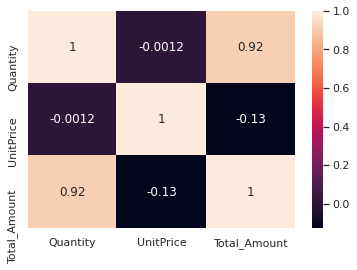

In [ ]:
#Show correlation between the total amount spend and quantity
import seaborn as sns
data_corr = data[['Quantity','UnitPrice']]
data_corr['Total_Amount'] = data['Quantity'] * data['UnitPrice']
sns.heatmap(data_corr.corr(), annot=True)
plt.show()

There is high correlation between the total amount that customer spend with the quantity. 

###2.1 Overall transaction

In [ ]:
#set the transaction variables
transaction = data.copy()
transaction['transaction'] = 1

#normalizing the date and grouping the overall transaction each date
transaction['InvoiceDate'] = transaction['InvoiceDate'].dt.normalize() #delete the time
transaction = transaction.groupby('InvoiceDate')['transaction'].sum().reset_index()

print('The Start Date of Transaction:', transaction['InvoiceDate'].min())
print('The Last Date of Transaction:', transaction['InvoiceDate'].max())

#Visualizing the overall transaction each date
fig = px.area(transaction, x = 'InvoiceDate', y = 'transaction')
fig.update_layout(xaxis_rangeslider_visible = True)
fig.show()

The Start Date of Transaction: 2010-12-01 00:00:00
The Last Date of Transaction: 2011-12-09 00:00:00


The transaction shows that the increasing order starts from September 2011 until December 2011. 

### 2.2 Countries
I am curious which countries have big transaction

In [ ]:
#How many countries that the transaction exist
amount_country = data['Country'].value_counts().reset_index()
print('Total Country:', len(amount_country))

Total Country: 37


In [ ]:
#Mapping the order
fig = go.Figure(data=go.Choropleth(
        locations = amount_country['index'],
        locationmode = 'country names',
        z = amount_country['Country'],
        text = amount_country['index'],
        colorscale = 'YlGn',
        autocolorscale = False,
        reversescale = False,
        marker_line_color = 'darkgray',
        marker_line_width = 0.8,
        colorbar_tickprefix = '',
        colorbar_title = 'Number<br>Orders',))

fig.update_layout(
        title_text = 'Number of Orders per Country',
        geo = dict(showframe = False,
                   showcoastlines = False,
                   projection_type = 'equirectangular'),
        annotations = [dict(
                   x = 0.55,
                   y = 0.1,
                   xref = 'paper',
                   yref = 'paper',
                   text='Source: <a href="https://archive.ics.uci.edu/ml/datasets/Online+Retail+II">\
                   UCI Machine Learning Repository</a>',
            showarrow = False
    )]
)

fig.show()

The **most transaction** happens in **United Kingdom** and the rest are in USA, Canada, Brazil, Australia, Japan, Saudi Arabia, and many more.

###2.3 Customer & Product
There are around 400.000 data point in the dataset, it makes me curious how many unique customer, products and transaction.

In [ ]:
pd.DataFrame([{'Product':len(data['Description'].value_counts()),
               'Customer':len(data['CustomerID'].value_counts()),
               'Transaction':len(data['InvoiceNo'].value_counts())}], columns = ['Product','Customer','Transaction'],
               index = ['Quantity'])

,Product,Customer,Transaction
Quantity,3896,4372,22190


It seems that customer buy the same product with other customers. However, the number of invoice is high and it looks like the customer buy and buy again in the different time

In [ ]:
nb_product = data.groupby(by=['CustomerID','InvoiceNo'], as_index = False)['Quantity'].sum()
nb_product.sort_values('CustomerID', ascending=True)[:10]

,CustomerID,InvoiceNo,Quantity
0,12346.0,541431,74215
1,12346.0,C541433,-74215
2,12347.0,537626,319
3,12347.0,542237,315
4,12347.0,549222,483
5,12347.0,556201,196
6,12347.0,562032,277
7,12347.0,573511,676
8,12347.0,581180,192
12,12348.0,568172,217


Hold on, the InvoiceNo is not always number but there is a letter **C** in front. I am curious what is the meaning of the letter.

In [ ]:
data[(data['InvoiceNo'] == 'C541433') | (data['InvoiceNo'] == 541431)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom


My curiousity has been fulfilled that the **C** letter in front of number means **Cancellation**. 

For example, **Invoice number 541431** has **74215 quantities** and **the Invoice number C541433** has **negative 74215**. It means, the customer cancel the transaction and return the quantity into 0

###2.4 Handling Cancellation

In [ ]:
#labeling the cancel invoiceNo with 1
nb_product['Labelling Cancellation Order'] = nb_product['InvoiceNo'].astype(str).apply(lambda x:int('C' in x))
display(nb_product[:10])
total_cancel = nb_product['Labelling Cancellation Order'].sum()
total_transaction = nb_product.shape[0]
print('The percentage of cancellation ({}/{}): {:.2f}%'.format(total_cancel, total_transaction,
                                                             total_cancel/total_transaction*100))

,CustomerID,InvoiceNo,Quantity,Labelling Cancellation Order
0,12346.0,541431,74215,0
1,12346.0,C541433,-74215,1
2,12347.0,537626,319,0
3,12347.0,542237,315,0
4,12347.0,549222,483,0
5,12347.0,556201,196,0
6,12347.0,562032,277,0
7,12347.0,573511,676,0
8,12347.0,581180,192,0
9,12348.0,539318,1254,0


The percentage of cancellation (3654/22190): 16.47%


Well, there is **16.47% cancellation** happens in the transaction. I am going to check if there is any cancellation of a transaction that has previously been done

In [ ]:
data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [ ]:
data_check = data[data['Quantity'] < 0][['StockCode','Description','Quantity','CustomerID','InvoiceDate']]

for index, col in data_check.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[2]) & 
            (data['Description'] == col[1]) & (data['InvoiceDate'] < col[4])].shape[0] == 0:
        print(data_check.loc[index])
        print(15*'-'+'>'+' Hypothesis Is not Fulfilled')
        break

StockCode                        D
Description               Discount
Quantity                        -1
CustomerID                   14527
InvoiceDate    2010-12-01 09:41:00
Name: 141, dtype: object
---------------> Hypothesis Is not Fulfilled


In [ ]:
display(data[(data['CustomerID'] == 14527) & (data['Description'] == 'Discount')])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
9038,C537164,D,Discount,-1,2010-12-05 13:21:00,29.29,14527.0,United Kingdom
31663,C539003,D,Discount,-1,2010-12-15 12:35:00,26.93,14527.0,United Kingdom
38609,C539589,D,Discount,-1,2010-12-20 13:14:00,13.88,14527.0,United Kingdom
44405,C540171,D,Discount,-1,2011-01-05 12:26:00,22.97,14527.0,United Kingdom
89282,C543840,D,Discount,-1,2011-02-14 11:19:00,70.01,14527.0,United Kingdom
108071,C545476,D,Discount,-1,2011-03-03 11:05:00,30.38,14527.0,United Kingdom
115091,C546106,D,Discount,-1,2011-03-09 12:21:00,9.87,14527.0,United Kingdom
140795,C548462,D,Discount,-1,2011-03-31 12:11:00,14.52,14527.0,United Kingdom
169834,C551265,D,Discount,-1,2011-04-27 12:06:00,11.76,14527.0,United Kingdom


Hmmmmm, the description shows about discount and it shows that StockCode also shows **D**. Let's stick on the previous cancellation

In [ ]:
data[(data['InvoiceNo'] == 'C541433') | (data['InvoiceNo'] == 541431)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom


Yes, there is a previouse order before cancelling the order. However, I will check if there is any cancelation without previous order.

Here is the definition:
- I try to do a new approachment by finding the cancellation with a counterpart
- The cancellation without counterpart perhaps there are transaction before the range date in dataset.

In [ ]:
data_cleaned = data.copy(deep = True)
data_cleaned['QuantityCanceled'] = 0

without_counterpart = [] ; with_counterpart = []

for index, col in data.iterrows():
    if (col['Quantity'] > 0): continue
    data_test = data[(data['Quantity'] > 0) & (data['CustomerID'] == col['CustomerID']) & 
                     (data['StockCode'] == col['StockCode']) & (data['InvoiceDate'] < col['InvoiceDate'])].copy()
        
#without counterpart
    if (data_test.shape[0] == 0):
        without_counterpart.append(index)
        

#with one counterpart
    elif (data_test.shape[0] == 1):
        with_counterpart.append(index)
        
#with more than one counterpart
    elif(data_test.shape[0] > 1):
        data_test.sort_index(axis = 0, ascending = False, inplace = True)
        for key, value in data_test.iterrows():
            if value['Quantity'] < -col['Quantity']: continue
            data_cleaned.loc[key, 'QuantityCanceled'] = -col['Quantity']
            with_counterpart.append(index)
            break

Here is how many cancellation from the two cases respectively `with_counterpart` and `without_counterpart`

In [ ]:
print('Number of cancellation with counterparts:', len(with_counterpart))
print('Number of cancellation without counterparts:', len(without_counterpart))

Number of cancellation with counterparts: 7521
Number of cancellation without counterparts: 1303


I have calculated that the total cancellation with or without counterparts are 8824 transaction. 

###2.5 Stock Code
In the previous cancellation display, I see there is StockCode with **D** which means discount. I am curious what kind of stock that contains other label.

In [ ]:
unique_code = data_cleaned[data_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex = True, na=False)]['StockCode'].unique()
unique_code

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

In [ ]:
for code in unique_code:
    print('{:<15}-> {:<30}'.format(code, data_cleaned[data_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST           -> POSTAGE                       
D              -> Discount                      
C2             -> CARRIAGE                      
M              -> Manual                        
BANK CHARGES   -> Bank Charges                  
PADS           -> PADS TO MATCH ALL CUSHIONS    
DOT            -> DOTCOM POSTAGE                
CRUK           -> CRUK Commission               


Well, there is some labels that we finally understand inside of the description

###2.6 Basket Price

In this section, I will retrieve the information about how much money the customer spend in the online retail.

In [ ]:
data_cleaned['TotalPrice'] = (data_cleaned['Quantity'] - data_cleaned['QuantityCanceled']) * data_cleaned['UnitPrice']
data_cleaned[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34


In [ ]:
temp = data_cleaned.groupby(by = ['CustomerID', 'InvoiceNo'], as_index = False)['TotalPrice'].sum()
basket_price = temp.rename(columns={'TotalPrice':'BasketPrice'})

basket_price = basket_price[basket_price['BasketPrice'] > 0]

basket_price.head()

,CustomerID,InvoiceNo,BasketPrice
0,12346.0,541431,77183.60
2,12347.0,537626,711.79
3,12347.0,542237,475.39
4,12347.0,549222,636.25
5,12347.0,556201,382.52


Basket price has been calculated in each transaction. In order to visualize it clearly, I decide to divide it with the total price

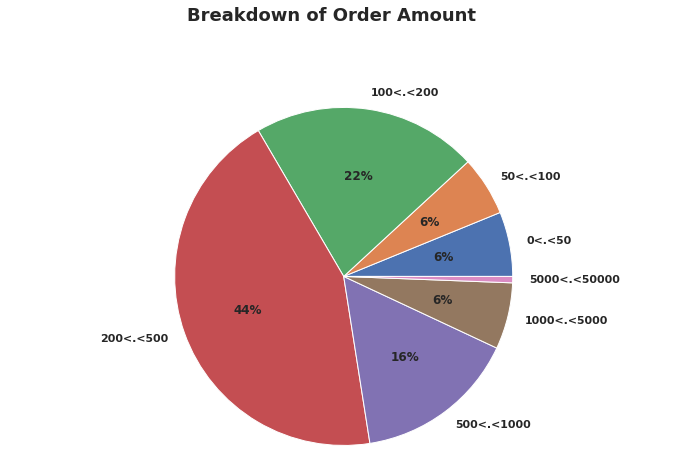

In [ ]:
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []

for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['BasketPrice'] < price) & (basket_price['BasketPrice'] > price_range[i-1])]['BasketPrice'].count()
    
    count_price.append(val)
    
#Visualization
plt.rc('font', weight = 'bold')
fig, ax = plt.subplots(figsize = (12, 7))
labels = ['{}<.<{}'.format(price_range[i-1], s) for i, s in enumerate(price_range) if i != 0]
size = count_price
explode = [0.0 if size[i] < 100 else 0.0 for i in range(len(size))]
ax.pie(size, explode = explode, labels = labels, autopct = lambda x: '{:1.0f}%'.format(x) if x > 1 else '',
      shadow = False, startangle = 0)
ax.axis('equal')
fig.text(0.5, 1.01, 'Breakdown of Order Amount', ha = 'center', fontsize = 18, fontweight = 'semibold')
plt.show()

From the pie chart, it shows that most customer spend money from £ 200 to £ 500.

##**3. Product Categories**

### 3.1 Description of product
I am going to analyse the content in the Description variable by following this operation:

- Extract each name appearing in the description
- For each name, I extract the root word and set an aggregation with the particular root
- Count the number of root word appear
- If the several words are listed in root word, I consider to use the shortest name (the function will select the singular word instead of plural)

In [ ]:
#extract the singular word
noun = lambda pos: pos[:2] == 'NN'

def keywords(df, col = 'Description'):
    stemmer = nltk.stem.SnowballStemmer('english')
    keywords_roots = dict() #collect the words
    keywords_select = dict() 
    category_keys = []
    count_keywords = dict()
    count_i = 0
    for s in df[col]:
        if pd.isnull(s): continue 
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if noun(pos)]
        
        for t in nouns:
            t = t.lower(); racine = stemmer.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k; min_length = len(k)
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
            
    print('Number of Keywords: {}'.format(len(category_keys)))
    return keywords_roots, keywords_select, category_keys, count_keywords

Once we have finished the function. Let's create new dataframe only show **Description** variable

In [ ]:
data_description = pd.DataFrame(data['Description'].unique()).rename(columns={0:'Description'})
print('Number of Products:', len(data_description))

Number of Products: 3896


In [ ]:
keywords_roots, keywords_select, category_keys, count_keywords = keywords(data_description)

Number of Keywords: 1483


With the function above, the variable shows:

- keywords = the list of extracted words
- keywords_roots = the word that is based on the root word
- count_keywords = listing the number of words appear and count it

In [ ]:
#changing the count_keywords from dictionary into list
list_products = []
for key, value in count_keywords.items():
    list_products.append([keywords_select[key],value])
list_products.sort(key = lambda x: x[1], reverse = True)

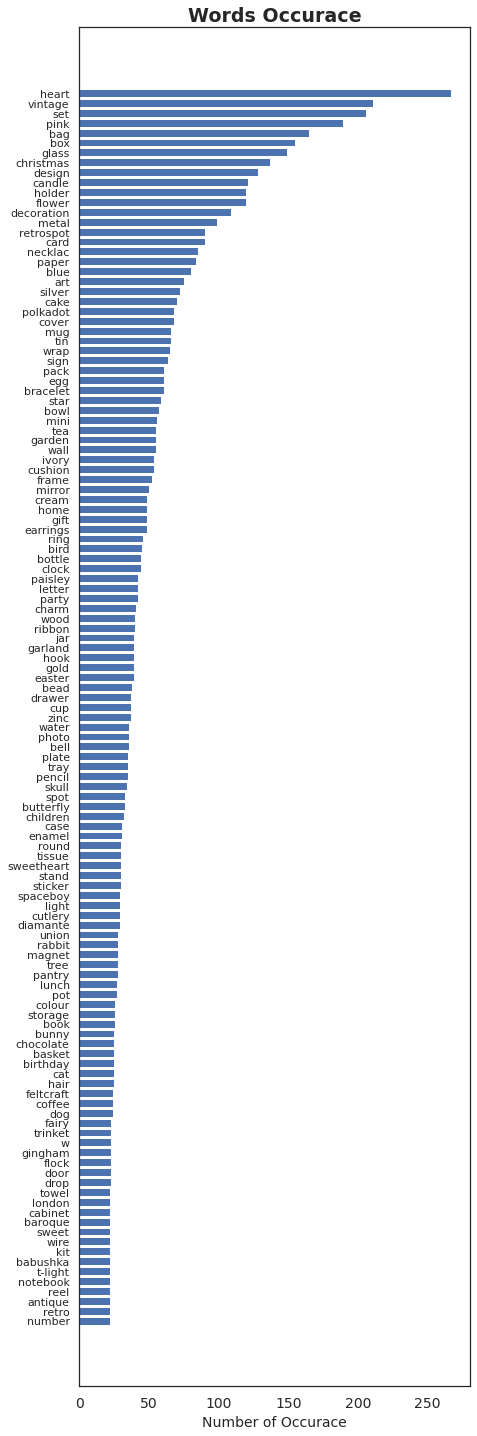

In [ ]:
#Visualizing the keywords with horizontal bar
listing = sorted(list_products, key = lambda x: x[1], reverse = True)

plt.rc('font', weight = 'normal')
fig, ax = plt.subplots(figsize = (7,25))
y_axis = [i[1] for i in listing[:125]]
x_axis = [k for k, i in enumerate(listing[:125])]
x_label = [i[0] for i in listing[:125]]
plt.yticks(x_axis, x_label)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
plt.xticks(fontsize = 14)
plt.xlabel('Number of Occurace', fontsize = 14, labelpad = 5)
plt.title('Words Occurace', fontsize = 19, fontweight='semibold')
plt.show()

### 3.2 Product Categories

In the product variables, we have known that there are 3896 different products with 1483 different keywords. However, we see from the bar chart that the highest keywords come from word 'pink'. Because I just want categorize the product not the color of the product, so I decide to delete the color keywords

In [ ]:
list_products = []
for key, value in count_keywords.items():
    word = keywords_select[key]
    if word in ['pink','blue','green','tag','ass','set']: continue
    if len(word) < 3 or value < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, value])
    
list_products.sort(key = lambda x:x[1], reverse = True)
print('The rest of Number of Keywords:',len(list_products))

The rest of Number of Keywords: 192


###3.3 Data Encoding
Keywords will be used to group the product

In [ ]:
list_description = data_cleaned['Description'].unique()
X = pd.DataFrame()
for key, value in list_products:
    X.loc[:, key] = list(map(lambda x: int(key.upper() in x), list_description))

The X matrix indicates the word contained in the description of the products using one-hot-encoding priciple. I also add 6 more columns to the matrix to indicate the price range of the products

In [ ]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold) -1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i], threshold[i+1])
    label_col.append(col)
    X.loc[:,col] = 0
    
for i, product in enumerate(list_description):
    prix = data_cleaned[data_cleaned['Description'] == product]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j += 1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [ ]:
print("{:<8} {:<20} \n".format('Group','Number of Products') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i], threshold[i+1])
    print("{:<10} {:<20}".format(col, X.loc[:, col].sum()))

Group    Number of Products   
--------------------
0<.<1      965                 
1<.<2      1013                
2<.<3      674                 
3<.<5      611                 
5<.<10     476                 
.>10       157                 


###3.4 Clustering the products
In this section, I am going to group the product into the different classes. In this matrix with binary encoding using sklearn package such as **Kmodes**

In order to define the number of cluster that represents the best data, I use silhouette score:

In [ ]:
matrix = X.to_numpy()
for n_clusters in range(3,15):
    kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters,
                   n_init = 30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print('n_cluster = ', n_clusters, "The Average of Silhouette Score:", silhouette_avg)


n_cluster =  3 The Average of Silhouette Score: 0.10489717742441915
n_cluster =  4 The Average of Silhouette Score: 0.1071769248402953
n_cluster =  5 The Average of Silhouette Score: 0.1521618024603827
n_cluster =  6 The Average of Silhouette Score: 0.15079318326599014
n_cluster =  7 The Average of Silhouette Score: 0.13313816613610405
n_cluster =  8 The Average of Silhouette Score: 0.15419970583564097
n_cluster =  9 The Average of Silhouette Score: 0.15523816465140394
n_cluster =  10 The Average of Silhouette Score: 0.1529637180488664
n_cluster =  11 The Average of Silhouette Score: 0.12491617346727633
n_cluster =  12 The Average of Silhouette Score: 0.1358012504863195
n_cluster =  13 The Average of Silhouette Score: 0.11621420074543598
n_cluster =  14 The Average of Silhouette Score: 0.14430978616822024


Silhouette analysis is one of the model to select the number of clusters. Based on the Scikit Learn Documentation, the silhouette coefficient near +1 indicate the sample is far away from the neighboring clusters which is good and value of 0 indicates that sample is on or very close to the decision boundary between two neighboring clusters, and negative values indicate that those samples might be assigned to the wrong cluster.

In this practice, we obtain the scores of 0.1±0.05 after n_clusters > 5. On the other hand, I found the score will drop after the n_cluster > 5. I therefore choose to seperate the dataset into 5 clusters

In [ ]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.143:
    kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, 
                   n_init = 30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    print('For Number of Cluster: ',n_clusters, 'The Silhouette Score: ',silhouette_avg)

For Number of Cluster:  5 The Silhouette Score:  0.1521618024603827


In [ ]:
pd.Series(clusters).value_counts()

4    1013
1     965
2     674
3     633
0     611
dtype: int64

From the Scikit Learn Documentation, to have an insight on the quality of the classification, we can represent the silhouette score in each element of the different clusters.

In [ ]:
list_ = pd.DataFrame(list_description)
list_words = [word for (word, occurance) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    list_cluster = list_.loc[clusters == i]
    for word in list_words:
        if word in ['pink','blue','green','tag','ass','set']: continue
        occurence[i][word] = sum(list_cluster.loc[:,0].str.contains(word.upper()))

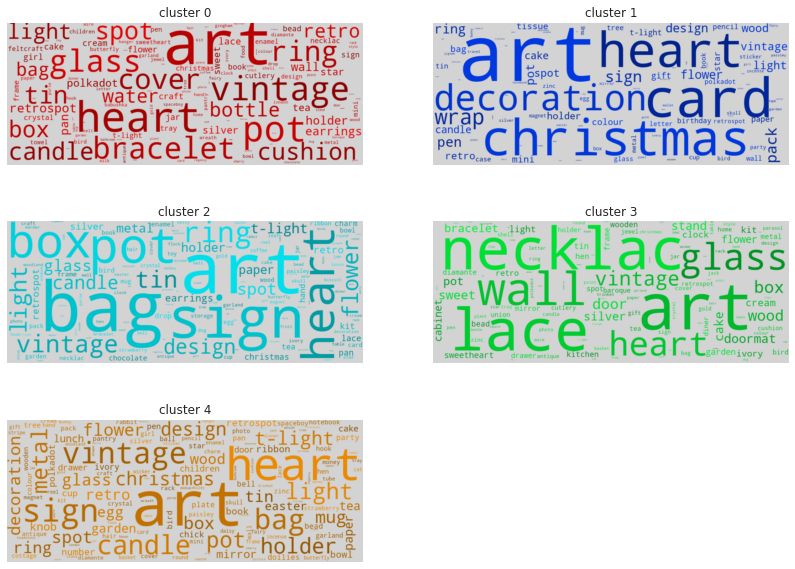

In [ ]:
#colorring the cluster
def colors_cluster(word = None, position=None, font_size=None, orientation=None,
                  font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

#making the word
def wordcloud(list_, increment):
    ax1 = fig.add_subplot(4,2, increment)
    words = dict()
    trunc_occurences = list_[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
        
    wordcloud = WordCloud(width = 1000, height =400, background_color='lightgrey',
                         max_words = 1500, relative_scaling = 1,
                         color_func = colors_cluster, normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation='bilinear')
    ax1.axis('off')
    plt.title('cluster {}'.format(increment-1))
    
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110,25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]
    
    tone = color[i]
    list_ = []
    for key, value in list_cluster_occurences.items():
        list_.append([key, value])
    list_.sort(key = lambda x: x[1], reverse = True)
    wordcloud(list_, i+1)

From this clustering, we have obtained that one of the clusters contains objects that are associated with luxury items (keywords: necklace, bracelet, silver) and some of them are associated with gifts (keywords: christmas, party, candle, card). However, the keywords are also appeared in other clusters which is difficult to distinguish them.

### 3.5 Principal Component Analysis (PCA)

In order to distinguish the objects clearly, I look at their composition. Given the large number of objects of the initial matrix, I do a PCA model

In [ ]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

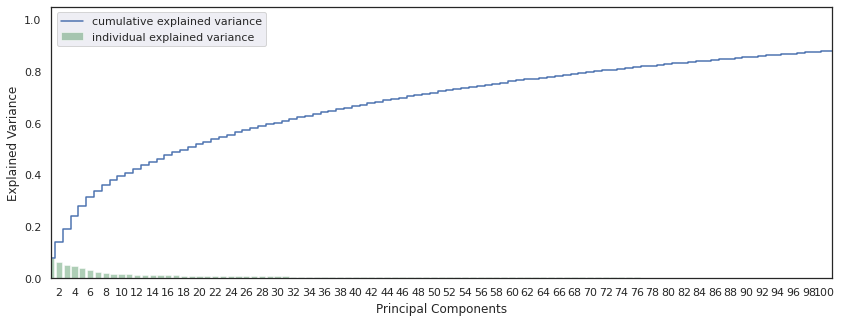

In [ ]:
fig, ax = plt.subplots(figsize = (14,5))
sns.set(font_scale = 1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(),
        where = 'mid', label = 'cumulative explained variance')
sns.barplot(np.arange(1, matrix.shape[1]+1), pca.explained_variance_ratio_, alpha = 0.5,
           color = 'g', label = 'individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text()) % 2 == 0 else '' for s in ax.get_xticklabels()])
plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.legend(loc = 'upper left')
plt.show()

We see that the number of components required to explain the data is necessarily important. We need more components to explain the 90% of variance of the data. However, I only keep the limited number of components due to use it only for visualizing the data

In [ ]:
pca = PCA(n_components = 50)
matrix_new = pca.fit_transform(matrix)
prod = pd.DataFrame(matrix_new)
prod['cluster'] = pd.Series(clusters)

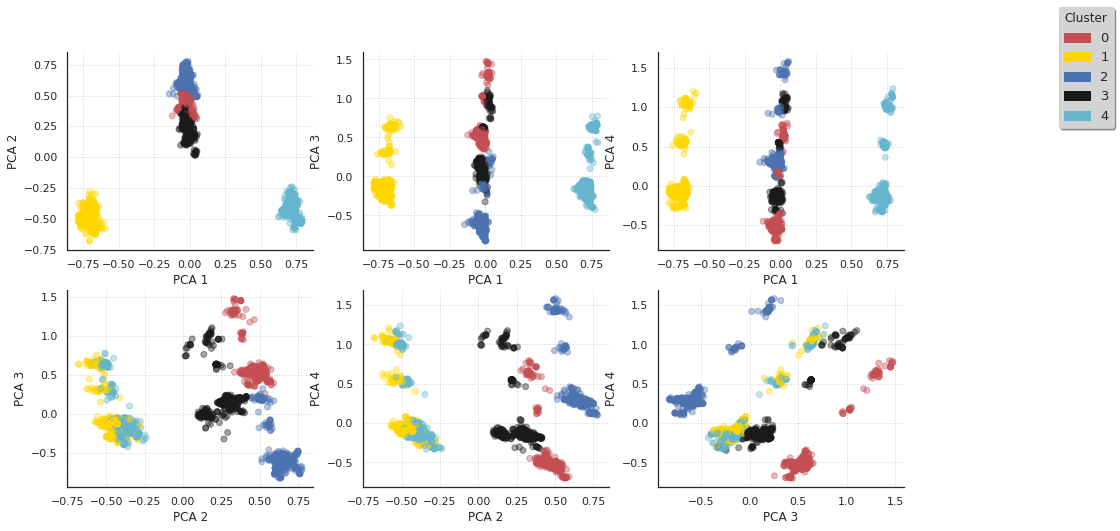

In [ ]:
sns.set_style('white')
sns.set_context('notebook', font_scale = 1, rc={'lines.linewidth': 2.5})

color_map = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g',6:'tomato',7:'deeppink'}
label_color = [color_map[l] for l in prod['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):
        increment += 1
        ax = fig.add_subplot(2, 3, increment)
        ax.scatter(prod[ix], prod[iy], c = label_color, alpha = 0.4)
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color = 'lightgray', linestyle = ':')
        ax.xaxis.grid(color = 'lightgray', linestyle = ':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
        
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = color_map[i], label = i))
    
plt.legend(handles = comp_handler, bbox_to_anchor = (1.1, 0.97),
          title = 'Cluster', facecolor = 'lightgrey', shadow = True,
          frameon = True, framealpha = 1, fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

##**4. Customer Segmentation**

### 4.0 Create Dataframe

From the previous section, we have finished to cluster the products into six clusters. In order to do the next analysis, I convert this information into dataframe. By doing this, I create categorical variable where I indicate the cluster of each product

In [ ]:
cor = dict()
for key, value in zip(list_description, clusters):
    cor[key] = value
    
data_cleaned['category_product'] = data_cleaned.loc[:, 'Description'].map(cor)

After that, I create category_n columns that contains the amount of spent in each product category

In [ ]:
for i in range(5):
    col = 'category_{}'.format(i)
    data_temp = data_cleaned[data_cleaned['category_product'] == i]
    price_temp = data_temp['UnitPrice'] * (data_temp['Quantity'] - data_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    data_cleaned.loc[:, col] = price_temp
    data_cleaned[col].fillna(0, inplace = True)

In [ ]:
data_cleaned[['InvoiceNo', 'Description', 'category_product', 'category_0','category_1','category_2','category_3', 'category_4']][5:10]

,InvoiceNo,Description,category_product,category_0,category_1,category_2,category_3,category_4
5,536365,SET 7 BABUSHKA NESTING BOXES,3,0.0,0.0,0.0,15.3,0.00
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,0,25.5,0.0,0.0,0.0,0.00
7,536366,HAND WARMER UNION JACK,2,0.0,0.0,11.1,0.0,0.00
8,536366,HAND WARMER RED POLKA DOT,4,0.0,0.0,0.0,0.0,11.10
9,536367,ASSORTED COLOUR BIRD ORNAMENT,4,0.0,0.0,0.0,0.0,54.08


From this, we have categorize the product and followed by price. After this, I decide to collect all orders and put in a single entry. So I create new dataframe that contains for each order, the amount of basket, as well as the way it is distributed over the 5 categories of the product.

In [ ]:
temp = data_cleaned.groupby(by = ['CustomerID', 'InvoiceNo'], as_index = False)['UnitPrice'].sum()
basket_price = temp.rename(columns = {'UnitPrice':'Basket_Price'})

for i in range(5):
    col = 'category_{}'.format(i)
    temp = data_cleaned.groupby(by = ['CustomerID','InvoiceNo'], as_index = False)[col].sum()
    basket_price.loc[:,col] = temp
    
data_cleaned['InvoiceDate_'] = data_cleaned['InvoiceDate'].astype('int64')
temp = data_cleaned.groupby(by = ['CustomerID','InvoiceNo'], as_index = False)['InvoiceDate_'].mean()
data_cleaned.drop('InvoiceDate_', axis = 1, inplace=True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_'])

basket_price = basket_price[basket_price['Basket_Price'] > 0]
basket_price.sort_values('CustomerID', ascending=True)[:5]

,CustomerID,InvoiceNo,Basket_Price,category_0,category_1,category_2,category_3,category_4,InvoiceDate
0,12346.0,541431,1.04,0.00,0.00,0.0,0.00,77183.6,2011-01-18 10:01:00.000000000
1,12346.0,C541433,1.04,0.00,0.00,0.0,0.00,0.0,2011-01-18 10:17:00.000000000
2,12347.0,537626,89.59,293.35,23.40,83.4,124.44,187.2,2010-12-07 14:57:00.000001024
3,12347.0,542237,73.17,169.20,84.34,53.1,38.25,130.5,2011-01-26 14:29:59.999999744
4,12347.0,549222,62.29,115.00,81.00,71.1,38.25,330.9,2011-04-07 10:42:59.999999232


### 4.1 Separating the data over time

The dataframe basket_price contains information over the period of 12 months. One of the objectives will be to develop a model and anticipating the habits of customer visiting the sites, from their first visit. In order to be able to test the model in reality, I split the data set by retaining the first 10 months to develope the model and the last 2 months to test.

In [ ]:
print('Initial transaction:', basket_price['InvoiceDate'].min())
print('Last transaction', basket_price['InvoiceDate'].max())


Initial transaction: 2010-12-01 08:26:00
Last transaction 2011-12-09 12:50:00


In [ ]:
#keep date only
basket_price['InvoiceDate'] = basket_price['InvoiceDate'].dt.date

In [ ]:
train_data = basket_price[basket_price['InvoiceDate'] < datetime.date(2011,10,1)]
test_data = basket_price[basket_price['InvoiceDate'] >= datetime.date(2011,10,1)]
basket_price = train_data.copy(deep = True)

### 4.2 Consumer Combinations

After grouping the transaction, I will group the transaction each customer. Thus, I determine the number of purchase made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all visits.

In [ ]:
transaction_user = basket_price.groupby(by=['CustomerID'])['Basket_Price'].agg(['count','min','max','mean','sum'])

for i in range(5):
    col = 'category_{}'.format(i)
    transaction_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum()/transaction_user['sum']*100
    

In [ ]:
transaction_user = transaction_user.reset_index()
transaction_user.head()

,CustomerID,count,min,max,mean,sum,category_0,category_1,category_2,category_3,category_4
0,12346.0,2,1.04,1.04,1.0400,2.08,0.000000,0.000000,0.000000,0.000000,3.710750e+06
1,12347.0,5,53.62,89.59,69.3820,346.91,260.721801,84.010262,116.848750,102.876827,2.400334e+02
2,12348.0,4,42.01,49.60,44.6775,178.71,0.000000,382.317721,0.000000,201.443680,4.219126e+02
3,12350.0,1,65.30,65.30,65.3000,65.30,0.000000,59.877489,142.879020,61.255743,2.480858e+02
4,12352.0,10,16.69,840.30,212.4570,2124.57,16.036186,0.480097,4.956297,65.926282,1.495173e+01


In [ ]:
basket_price.groupby(by=['CustomerID'])['category_0'].sum()
transaction_user['CustomerID'] = transaction_user['CustomerID'].astype('int64')
transaction_user.sort_values('CustomerID', ascending=True)[:5]

,CustomerID,count,min,max,mean,sum,category_0,category_1,category_2,category_3,category_4
0,12346,2,1.04,1.04,1.0400,2.08,0.000000,0.000000,0.000000,0.000000,3.710750e+06
1,12347,5,53.62,89.59,69.3820,346.91,260.721801,84.010262,116.848750,102.876827,2.400334e+02
2,12348,4,42.01,49.60,44.6775,178.71,0.000000,382.317721,0.000000,201.443680,4.219126e+02
3,12350,1,65.30,65.30,65.3000,65.30,0.000000,59.877489,142.879020,61.255743,2.480858e+02
4,12352,10,16.69,840.30,212.4570,2124.57,16.036186,0.480097,4.956297,65.926282,1.495173e+01


In ecommerce, it is interesting to see the customers who only make one purchase. One of the objectives is to target this customer in order to retain them. So, I try to calculate how many customer who make one purchase

In [ ]:
one_purchase = transaction_user[transaction_user['count'] == 1].shape[0]
total_users = transaction_user.shape[0]

print("Number of users who only make one purchase: ", one_purchase)
print("In percentage: {:.2f}%".format(one_purchase/total_users*100))

Number of users who only make one purchase:  1265
In percentage: 34.58%


There are 34.58% of users who only make one purchase

### 4.3 Creating Customer Categories

In [ ]:
columns = ['count', 'min', 'max', 'mean', 'category_0',
            'category_1', 'category_2', 'category_3', 'category_4']

selected_customer = transaction_user.copy(deep = True)
matrix = selected_customer[columns].to_numpy()

In practice, the different variables have the different range of variation and before analysing the rest, I create a matrix to standardize the data

In [ ]:
scaler = StandardScaler()
scaler.fit(matrix)
print(scaler.mean_)
scaled_matrix = scaler.transform(matrix)

[   4.35128486   38.07497048  113.17263341   64.74992691  148.10543703
  524.58141733  275.56623553  172.66621143 1383.19808585]


### 4.4 Clustering the customer

In this section, I do the same thing in product to cluster the customer using KMeans from scikit-learn. I already iterate number of clusters and get the best silhouette scores with 9 clusters

In [ ]:
n_clusters = 9
kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_customers = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_customers)
print(' n_cluster:', n_clusters, '\n','The Average of Silhouette Score:', silhouette_avg)

 n_cluster: 9 
 The Average of Silhouette Score: 0.8236775297546638


The following section, It remains to understand the behaviour of customers in each cluster. I am going to start adding the selected_customers dataframe that defines the cluster to which each customer belong

In [ ]:
selected_customer.loc[:, 'cluster'] = clusters_customers
selected_customer.head()

,CustomerID,count,min,max,mean,sum,category_0,category_1,category_2,category_3,category_4,cluster
0,12346,2,1.04,1.04,1.0400,2.08,0.000000,0.000000,0.000000,0.000000,3.710750e+06,1
1,12347,5,53.62,89.59,69.3820,346.91,260.721801,84.010262,116.848750,102.876827,2.400334e+02,0
2,12348,4,42.01,49.60,44.6775,178.71,0.000000,382.317721,0.000000,201.443680,4.219126e+02,0
3,12350,1,65.30,65.30,65.3000,65.30,0.000000,59.877489,142.879020,61.255743,2.480858e+02,0
4,12352,10,16.69,840.30,212.4570,2124.57,16.036186,0.480097,4.956297,65.926282,1.495173e+01,0


After this, I am going to average the contents by selecting the different group of customer. For example, I do average the basket price, total sum spents by cutomer in different cluster. Then, I determine the number of clients in each group.

In [ ]:
data_merged = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customer[selected_customer['cluster'] ==i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customer[selected_customer['cluster'] == i ].shape[0]
    data_merged = pd.concat([data_merged, test])

data_merged.drop('CustomerID', axis = 1, inplace=True)
print('The amount of Customers', data_merged['size'].sum())

data_merged = data_merged.sort_values('sum')

The amount of Customers 3658


In [ ]:
data_merged = data_merged.reset_index()
data_merged['cluster'] = data_merged['cluster'].astype('int64')
data_merged

,cluster,count,min,max,mean,sum,category_0,category_1,category_2,category_3,category_4,size
0,7,1.000000,0.720000,0.720000,0.720000,0.720000,0.000000,430000.000000,0.000000,0.000000,0.000000e+00,1
1,1,2.000000,1.040000,1.040000,1.040000,2.080000,0.000000,0.000000,0.000000,0.000000,3.710750e+06,1
2,2,2.000000,3.980000,5.300000,4.640000,9.280000,0.000000,4034.482759,0.000000,44637.931034,0.000000e+00,1
3,6,2.666667,3.701429,7.145238,5.236198,19.748095,123.732925,876.274006,15165.640750,1087.552195,1.878859e+03,21
4,5,5.000000,3.801429,14.094286,7.082292,36.387143,12405.647618,1053.963070,863.341446,0.000000,9.456119e+02,7
5,0,3.805246,36.606066,96.262995,61.010654,218.641756,121.434620,404.708380,184.516445,149.997933,3.585974e+02,3584
6,4,1.000000,2637.740000,2637.740000,2637.740000,2637.740000,0.000000,0.000000,0.000000,33.333333,0.000000e+00,3
7,8,55.769231,1.380769,559.998205,52.772131,3495.648718,438.720137,221.282326,569.038566,677.987981,4.538515e+02,39
8,3,5.000000,4.950000,38970.000000,8055.780000,40278.900000,0.000000,0.000000,0.000000,2.349866,0.000000e+00,1


##**5. Modelling Classification**
In this section, I am going to make an objective to classify the customer in the difference categories that were established in th previous section. To achieve the objective, I create a test several classifier implemented in scikit-learn

In [ ]:
class Class(object):
    def __init__(self, clf, params=None):
        if params:
            self.clf = clf(**params)
        else:
            self.clf = clf()
            
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict_test(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Testing Accuracy: {:.2f}%".format(100*metrics.accuracy_score(Y, self.predictions)))
        
    def grid_predict_train(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Training Accuracy: {:.2f}%".format(100*metrics.accuracy_score(Y, self.predictions)))

Because the goal is to define the class to which the customer belongs, as soon as its first visit, I only keep the variable that describe the content of the basket, and do not take into account the variables related the frequency of visits or variations of the basket price overtime

In [ ]:
columns = ['mean', 'category_0','category_1', 'category_2', 'category_3', 'category_4']
X = selected_customer[columns]
Y = selected_customer['cluster']

In [ ]:
#Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

Before using machine learning models, I create OOP to test the quality of the prediction in each model. The test to qualify the prediction is using learning curve. In particular, this type of curves allow to detect possible drawbacks in the model, linked for example to over and under fitting. In order to draw this curve, I use scikit learn documentation

In [ ]:
def plot_learning_curve(estimator, title, X, Y, ylim = None, cv = None,
                       n_jobs = 1, train_sizes = np.linspace(.1, 1.0, 10)):
    """
    Generate the plot of test and training learning curve
    """
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training Sample')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator,
                                                           X, Y, cv=cv, n_jobs=n_jobs,
                                                           train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha = 0.1, color = 'r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha = 0.1, color = 'g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label = 'Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label = 'Cross-validation curve')
    
    plt.legend(loc='best')
    return plt

### 5.1 Logistic Regression

In [ ]:
lr = Class(clf = LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2, 2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict_train(X_train, Y_train)
lr.grid_predict_test(X_test, Y_test)

Training Accuracy: 96.72%
Testing Accuracy: 95.90%


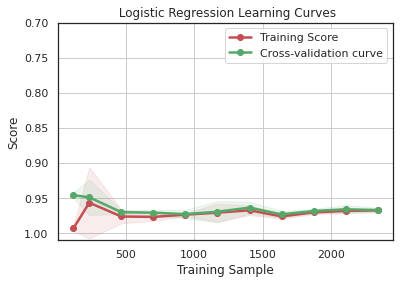

In [ ]:
g = plot_learning_curve(lr.grid.best_estimator_, ' Logistic Regression Learning Curves',
                       X_train, Y_train, ylim = [1.01, 0.7], cv = 5,
                       train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

From the above curve, we can see that the train and cross validation curves converge towards the same limit when the sample size increases. Model using logistic regression shows that the model is not overfitting. We can see also that the accuracy of training curve is correct with low bias. Hence the model does not underfit the data

### 5.2 Gradient Boosting

In [ ]:
gb = Class(clf = GradientBoostingClassifier)
param_grid = {'n_estimators': [20, 40, 60, 80, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict_train(X_train, Y_train)
gb.grid_predict_test(X_test, Y_test)

Training Accuracy: 100.00%
Testing Accuracy: 97.68%


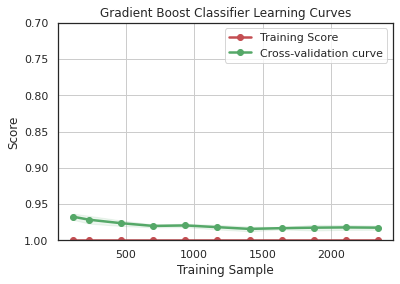

In [ ]:
g = plot_learning_curve(gb.grid.best_estimator_, 'Gradient Boost Classifier Learning Curves',
                       X_train, Y_train, ylim = [1.0, 0.7], cv = 5,
                       train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

Gradient boosting gives the result that the model is overfitting which it can predict 100% training data.

In [ ]:
param_grid = {'C':np.logspace(-2, 2,20)}

lr_tune = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=5)

#fit the model
lr_tune.fit(X_train, Y_train)
lr_tune.best_score_, lr_tune.best_params_    

(0.9712937195531053, {'C': 14.38449888287663})

In [ ]:
lr = LogisticRegression(C=14.3)
lr = lr.fit(X_train, Y_train)

In [ ]:
predictions = lr.predict(X_test)
predictions_train = lr.predict(X_train)
print("Training Accuracy: {:.2f}&".format(100*metrics.accuracy_score(Y_train, predictions_train)))
print("Testing Accuracy: {:.2f}&".format(100*metrics.accuracy_score(Y_test, predictions)))

Training Accuracy: 96.31&
Testing Accuracy: 95.36&


The result shows good. Now, it is ready to predict which customer belongs to specific cluster

##**6. Testing the predictions**

Based on the classification model above, I choose logistic regression with hyperparameter tuning to enhance the performance

In [ ]:
train_data = basket_price[basket_price['InvoiceDate'] < datetime.date(2011,10,1)]

In the previous section, we have done to create a model for our last 10 months as a train_data. In this section, I am going to test the model with the next two months as test_data

In [ ]:
testing_data = test_data.copy(deep = True)

We have a several steps in the following section:

- I am going to regroup these data according to the same procedures as used on the training data.
- I convert the dataframe into a matrix and retain only the specific variables. I will use the same procedure as used on the training data

In [ ]:
transaction_by_user = testing_data.groupby(by=['CustomerID'])['Basket_Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'category_{}'.format(i)
    transaction_by_user.loc[:,col] = testing_data.groupby(by=['CustomerID'])[col].sum()/transaction_by_user['sum']*100
    
transaction_by_user.reset_index(drop = False, inplace = True)

transaction_by_user['sum'] = transaction_by_user['count'] * transaction_by_user['mean']

transaction_by_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,category_0,category_1,category_2,category_3,category_4
0,12347.0,2,13.54,120.76,67.15,134.30,274.549516,143.618764,365.852569,120.699926,226.433358
1,12349.0,1,605.10,605.10,605.10,605.10,31.118823,13.108577,35.567675,133.672120,76.988927
2,12352.0,1,86.53,86.53,86.53,86.53,26.002542,24.037906,31.468855,154.744019,124.003236
3,12356.0,1,23.70,23.70,23.70,23.70,0.000000,0.000000,0.000000,246.202532,0.000000
4,12357.0,1,438.67,438.67,438.67,438.67,401.185401,72.026808,213.139718,472.644585,256.115075


In [ ]:
#Converting data into matrix
columns = ['count', 'min', 'max', 'mean', 'category_0',
       'category_1', 'category_2', 'category_3', 'category_4']

matrix_test = transaction_by_user[columns].to_numpy()
scaled_matrix_test = scaler.transform(matrix_test)

In [ ]:
Y = kmeans.predict(scaled_matrix_test)
X_columns = ['mean', 'category_0','category_1', 'category_2', 'category_3', 'category_4']
X = transaction_by_user[X_columns]

In [ ]:
predictions = lr.predict(X)
print("Accuracy: {:.2f}%".format(100*metrics.accuracy_score(Y, predictions)))

Accuracy: 96.77%


Logistic Regression with hyperparameter tuning give the good accuracy score around 96.77%.

By using this model, we can predict this customer needs more approachment to buy products with the high price. The more we can know what the customer needs, the more the online retail will get revenue.